# Cython

<img src="../img/cython-logo.png" style="height:150px">

Cython is a programming language that you can consider to be a superset of Python.  The Cython compiler will take Python code and compile it to C code, which in turn can be turned into machine code and used to generate a Python module. 

In short, Cython is Python with some of the performance feature of C.

In this notebook we'll go over some of the basics of Cython as well as several examples.


## Compiling Python code to C

If you were to run the Cython compiler on Python code, you'd get a working application, albeit one with no optimizations.  We can take our standard Python code, add some special syntax that Cython understands, and Cython will substitute in slow Python code for faster C equivalents.

We should point out that Cython is not going to automatically convert and optimise whole blocks of code for you.  Rather, it allows you to declare Python objects a equivalent C data types.  Remember the introductory slides that talked about type inference and how it slowed down Python?  Cython allows us to explicitly declare objects that will be converted/compiled in C code, giving us a performance boost later when we execute our code.

Let's start with a simple numerical integration example:

In [1]:
def f(x):
    return x**2 - x

def integrate_f(a, b, N):
    s = 0
    dx = (b-a)/N
    for i in range(N):
        s += f(a+i*dx)
    return s*dx

In [2]:
%timeit integrate_f(0, 1, 100000)

43.8 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Before we write the Cython version we first need to load the Cython magic command:

In [11]:
%load_ext Cython

We also need to prefix our cells with `%%cython` to tell Jupyter to use the Cython compiler.

In [4]:
%%cython

cdef double f(double x):
    return x**2-x

def integrate_f(double a, double b, int N):
    cdef int i
    cdef double s, x, dx
    s = 0
    dx = (b-a)/N
    for i in range(N):
        s += f(a+i*dx)
    return s * dx

In [5]:
%timeit integrate_f(0, 1, 100000)

135 µs ± 8.46 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


With just a few C defintions we've seen a performance improvement of 3 orders of magnitude!

You can try passing the `--annotate` flag to see the interaction between Python objects and C:

In [6]:
%%cython --annotate

cdef double f(double x):
    return x**2-x

def integrate_f(double a, double b, int N):
    cdef int i
    cdef double s, x, dx
    s = 0
    dx = (b-a)/N
    for i in range(N):
        s += f(a+i*dx)
    return s * dx

Yellow indicates a Python interaction, and the brighter it is the more interaction with Python the code section has.  You can see the C code that Cython has generated by clicking on a `+` (be warned...it's not always pretty).

## Astrophysics Demo

This demo is from https://github.com/adrn/cython-tutorial, and it walks through the numerical integration of an orbit under some external gravitational potential.

If you'd like the full mathematical description of the problem:

We want to numerically solve for $\boldsymbol{x}(t)$ and $\boldsymbol{v}(t)$ given a gravitational potential $\Phi(\boldsymbol{x})$ and initial conditions $\boldsymbol{x}_0$, $\boldsymbol{v}_0$. To do this, we'll use the Leapfrog integration scheme. With the gravitational potential, we'll need to write an expression and function to compute the acceleration $a(\boldsymbol{x})$. With initial conditions and the acceleration, Leapfrog integration works iteratively as follows:

$$
\begin{align}
\boldsymbol{x}_i &= \boldsymbol{x}_{i-1} + \boldsymbol{v}_{i-1/2}\,\Delta t\\
\boldsymbol{a}_i &= \boldsymbol{a}(\boldsymbol{x}_i)\\
\boldsymbol{v}_{i+1/2} &= \boldsymbol{v}_{i-1/2} + \boldsymbol{a}_i\,\Delta t
\end{align}
$$

In practice, we will want to store the positions and velocities at the synced timestep $i$. We'll therefore implement this scheme as:

$$
\begin{align}
\boldsymbol{x}_i &= \boldsymbol{x}_{i-1} + \boldsymbol{v}_{i-1/2}\,\Delta t\\
\boldsymbol{a}_i &= \boldsymbol{a}(\boldsymbol{x}_i)\\
\boldsymbol{v}_{i} &= \boldsymbol{v}_{i-1/2} + \boldsymbol{a}_i\,\frac{\Delta t}{2}\\
\boldsymbol{v}_{i+1/2} &= \boldsymbol{v}_{i} + \boldsymbol{a}_i\,\frac{\Delta t}{2}
\end{align}
$$

The acceleration function is just:

$$
\boldsymbol{a}(\boldsymbol{x}) = -\boldsymbol{\nabla} \Phi(\boldsymbol{x})
$$

For this example, we'll use the [Hernquist potential](http://adsabs.harvard.edu/abs/1990ApJ...356..359H), defined as:

$$
\Phi(r) = -\frac{G\,m}{r + c}
$$

The acceleration is therefore:

$$
\boldsymbol{a}(\boldsymbol{x}) = -\frac{G\,m}{(r + c)^2} \, \frac{\boldsymbol{x}}{r}
$$

We'll allow the parameters $m$ and $c$ to be changeable, but start by using:

$$
\begin{align}
m &= 10^{11}~{\rm M}_\odot\\
c &= 1~{\rm kpc}
\end{align}
$$

We'll first import some modules and create some parameters for our gravitational potential:

In [9]:
from astropy.constants import G
import astropy.units as u
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# The unit system we'll use:
units = [u.Myr, u.kpc, u.Msun]

# parameters of the gravitational potential
m = 1E11 # Msun
c = 1. # kpc

# value of G in our unit system
_G = G.decompose(units).value

And let's write a function to compute acceleration:

In [10]:
def hernquist_acceleration(xyz, G, m, c):
    r = np.sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + c)**2
    return -dPhi_dr * xyz / r

We'll use a [Leapfrog integration](https://en.wikipedia.org/wiki/Leapfrog_integration) method.  For those of you without a background in ODEs, we're basically going to do what is called predictor-corrector: step our simulation forward half a step (based on a guess), and then update that guess.  The numerical integration scheme has some nice benefits over some other methods (it's more accurate, more stable, and not computationally expensive).

Now let's write the Leapfrog Integration code:

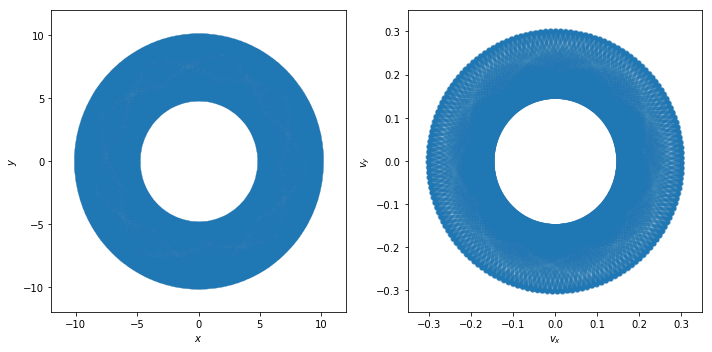

In [12]:
def leapfrog_hernquist(x0, v0, dt, n_steps, hernquist_args=()):
    
    # ensure that the initial conditions are arrays
    x0 = np.array(x0)
    v0 = np.array(v0)
    
    # Create arrays to store positions and velocities at all times
    x = np.zeros((n_steps+1, 3))
    v = np.zeros((n_steps+1, 3))
    t = np.zeros(n_steps+1)
    
    x[0] = x0
    v[0] = v0
    
    # Increment velocity by 1/2 step 
    v_iminus1_2 = v0 + dt/2. * hernquist_acceleration(x0, *hernquist_args)
    for i in range(1, n_steps+1):
        x[i] = x[i-1] + v_iminus1_2 * dt # full step
        
        a_i = hernquist_acceleration(x[i], *hernquist_args)
        v[i] = v_iminus1_2 + a_i * dt/2. # half step
        v_iminus1_2 = v[i] + a_i * dt/2. # another half step
        
        t[i] = t[i-1] + dt
    
    return t, x, v

# We'll define these so we can reuse them later:
x0 = [10., 0, 0]
v0 = [0, 0.15, 0]
dt = 1.
n_steps = 100000

t, x, v = leapfrog_hernquist(x0=x0, v0=v0,
                             dt=dt, n_steps=n_steps,  
                             hernquist_args=(_G, m, c))


fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].plot(x[:,0], x[:,1], marker='.', linestyle='none', alpha=0.1)
axes[0].set_xlim(-12, 12)
axes[0].set_ylim(-12, 12)

axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')

# ---

axes[1].plot(v[:,0], v[:,1], marker='.', linestyle='none', alpha=0.1)
axes[1].set_xlim(-0.35, 0.35)
axes[1].set_ylim(-0.35, 0.35)

axes[1].set_xlabel('$v_x$')
axes[1].set_ylabel('$v_y$')

fig.tight_layout()

In [13]:
%%time
_ = leapfrog_hernquist(x0=x0, v0=v0,
                       dt=dt, n_steps=n_steps, 
                       hernquist_args=(_G, m, c))

CPU times: user 1.98 s, sys: 0 ns, total: 1.98 s
Wall time: 1.99 s


This isn't terrible performance, but what if we wanted to do more time steps, or an N-body simulation?  What can we do to improve the performance:

* Algorithm improvements?  Leapfrog is a pretty simple integration scheme, so no
* Optimised Python code?  Not really
* Loop optimisation?  No, this is an iterative scheme, so we have to loop

Because we're focused on performance, let's look at this code in Cython.

### Leapfrog Integration and Cython

Just to illustrate the point about the language interoperability, let's try compiling our exact same code from above with the Cython compiler and see how it performs:

In [15]:
%%cython

import numpy as np

# abbreviated function name for laziness...
def acc_cy1(xyz, G, m, c):
    r = np.sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + c)**2
    return -dPhi_dr * xyz / r

# and another abbreviated function name for laziness...
def leapfrog_cy1(x0, v0, dt, n_steps, hernquist_args=()):
   
    # ensure that the initial conditions are arrays
    x0 = np.array(x0)
    v0 = np.array(v0)
    
    # Create arrays to store positions and velocities at all times
    x = np.zeros((n_steps+1, 3))
    v = np.zeros((n_steps+1, 3))
    t = np.zeros(n_steps+1)
    
    x[0] = x0
    v[0] = v0
    
    # Increment velocity by 1/2 step 
    v_iminus1_2 = v0 + dt/2. * acc_cy1(x0, *hernquist_args)
    for i in range(1, n_steps+1):
        x[i] = x[i-1] + v_iminus1_2 * dt # full step
        
        a_i = acc_cy1(x[i], *hernquist_args)
        v[i] = v_iminus1_2 + a_i * dt/2. # half step
        v_iminus1_2 = v[i] + a_i * dt/2. # another half step
        
        t[i] = t[i-1] + dt
    
    return t, x, v

In [16]:
%%time
leapfrog_cy1(x0=x0, v0=v0,
             dt=dt, n_steps=n_steps, 
             hernquist_args=(_G, m, c))

CPU times: user 1.75 s, sys: 0 ns, total: 1.75 s
Wall time: 1.75 s


(array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 9.9998e+04, 9.9999e+04,
        1.0000e+05]), array([[10.        ,  0.        ,  0.        ],
        [ 9.99814111,  0.15      ,  0.        ],
        [ 9.99256438,  0.29994422,  0.        ],
        ...,
        [ 0.20234305,  5.69765931,  0.        ],
        [-0.05808088,  5.77768755,  0.        ],
        [-0.31840639,  5.84792437,  0.        ]]), array([[ 0.        ,  0.15      ,  0.        ],
        [-0.00371781,  0.14997211,  0.        ],
        [-0.00743577,  0.14988842,  0.        ],
        ...,
        [-0.26024617,  0.0850338 ,  0.        ],
        [-0.26037472,  0.07513253,  0.        ],
        [-0.26006539,  0.06545956,  0.        ]]))

There's actually a small improvement, but not a lot.  Why?

Even though we're compiling this to C code, it still has to go through a Python layer when we run.  There's some delay in passing Python objects back and forth between the two layers.

What we really want to do is bypass that Python layer and just call C functions directly.  To do that we'll need to add C definitions like we saw in the small example above.

Before we do that, let's look at how our Leapfrog integration code is interacting between C and Python:

In [17]:
%%cython --annotate

import numpy as np

def acc_cy1(xyz, G, m, c):
    r = np.sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + c)**2
    return -dPhi_dr * xyz / r

def leapfrog_cy1(x0, v0, dt, n_steps, hernquist_args=()):
   
    # ensure that the initial conditions are arrays
    x0 = np.array(x0)
    v0 = np.array(v0)
    
    # Create arrays to store positions and velocities at all times
    x = np.zeros((n_steps+1, 3))
    v = np.zeros((n_steps+1, 3))
    t = np.zeros(n_steps+1)
    
    x[0] = x0
    v[0] = v0
    
    # Increment velocity by 1/2 step 
    v_iminus1_2 = v0 + dt/2. * acc_cy1(x0, *hernquist_args)
    for i in range(1, n_steps+1):
        x[i] = x[i-1] + v_iminus1_2 * dt # full step
        
        a_i = acc_cy1(x[i], *hernquist_args)
        v[i] = v_iminus1_2 + a_i * dt/2. # half step
        v_iminus1_2 = v[i] + a_i * dt/2. # another half step
        
        t[i] = t[i-1] + dt
    
    return t, x, v

That's a lot of yellow...we want to minimise that.

To start, lets explicitly set the types for our variables (as opposed to letting Python figure it out at runtime).  We'll also import NumPy such that we can access it from Cython:

In [18]:
%%cython --annotate

import numpy as np # access to Numpy from Python layer
cimport numpy as np # access to Numpy from Cython layer

# this is like #include <math.h>, but defines the functions in Cython
from libc.math cimport sqrt

def acc_cy2(np.ndarray[np.float64_t, ndim=1] xyz, double G, double m, double a):
    cdef:
        double r
        double dPhi_dr
        np.ndarray[np.float64_t, ndim=1] a_xyz = np.zeros(3, np.float64)
        
    r = sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + a)**2
    
    a_xyz[0] = -dPhi_dr * xyz[0] / r
    a_xyz[1] = -dPhi_dr * xyz[1] / r
    a_xyz[2] = -dPhi_dr * xyz[2] / r
    
    return a_xyz

It's looking better, but we can still improve on it.  One of the lines repeated in the analysis is `RaiseBufferIndexError`.  What that means is that Python is checking to see if you've gone out of bounds on array.  This is nice to have, but it adds overhead and we're pretty good programmers so we'll be careful when we write our code to make sure this doesn't happen.

We're also going to turn off some other checks with Cython compiler directives (more info can be found [here](http://cython.readthedocs.io/en/latest/src/reference/compilation.html#compiler-directives)):

In [19]:
%%cython --annotate

import numpy as np # access to Numpy from Python layer
cimport numpy as np # access to Numpy from Cython layer

# this is like #include <math.h>, but defines the functions in Cython
from libc.math cimport sqrt

cimport cython

@cython.boundscheck(False) # won't check that index is in bounds of array
@cython.wraparound(False) # array[-1] won't work
@cython.nonecheck(False) # variables are never set to None
@cython.cdivision(True) # don't protect against dividing by zero
def acc_cy3(np.ndarray[np.float64_t, ndim=1] xyz, double G, double m, double a):
    cdef:
        double r
        double dPhi_dr
        np.ndarray[np.float64_t, ndim=1] a_xyz = np.zeros(3, np.float64)
        
    r = sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + a)**2
    
    a_xyz[0] = -dPhi_dr * xyz[0] / r
    a_xyz[1] = -dPhi_dr * xyz[1] / r
    a_xyz[2] = -dPhi_dr * xyz[2] / r
    
    return a_xyz

Getting better...only a few lines of yellow.  All that's left is:

* the function definition
* creating the acceleration array
* returning the acceleration array

To get this to pure C code, we'll:
* define our acceleration function as a C function (only accessible from Cython)
* preallocate memory and pass in an array of a fixed size to return the acceleration values.

In [20]:
%%cython --annotate

import numpy as np # access to Numpy from Python layer
cimport numpy as np # access to Numpy from Cython layer

# this is like #include <math.h>, but defines the functions in Cython
from libc.math cimport sqrt

cimport cython

@cython.boundscheck(False) # won't check that index is in bounds of array
@cython.wraparound(False) # array[-1] won't work
@cython.nonecheck(False) # variables are never set to None
@cython.cdivision(True) # don't protect against dividing by zero
cdef void acc_cy4(np.ndarray[np.float64_t, ndim=1] xyz, double G, double m, double a,
                  np.ndarray[np.float64_t, ndim=1] a_xyz):
    cdef:
        double r
        double dPhi_dr
        
    r = sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + a)**2
    
    a_xyz[0] = -dPhi_dr * xyz[0] / r
    a_xyz[1] = -dPhi_dr * xyz[1] / r
    a_xyz[2] = -dPhi_dr * xyz[2] / r

So what did we do wrong for our acceleration function?

This function is expecting an array ***passed by value***.  To really optimise this we're going to pass the function a reference instead.  We can do that we can use a special type called a **memoryview**.  For those of you out there that know C/C++, this is like a pointer.

The point is, rather than wasting time copying in the whole array, we can simply tell the function where to look so it can quickly access the data:

In [22]:
%%cython --annotate

import numpy as np # access to Numpy from Python layer
cimport numpy as np # access to Numpy from Cython layer

# this is like #include <math.h>, but defines the functions in Cython
from libc.math cimport sqrt

cimport cython

@cython.boundscheck(False) # won't check that index is in bounds of array
@cython.wraparound(False) # array[-1] won't work
@cython.nonecheck(False) # variables are never set to None
@cython.cdivision(True) # don't protect against dividing by zero
cdef void acc_cy5(double[::1] xyz, double G, double m, double a,
                  double[::1] a_xyz):
    cdef:
        double r
        double dPhi_dr
        
    r = sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + a)**2
    
    a_xyz[0] = -dPhi_dr * xyz[0] / r
    a_xyz[1] = -dPhi_dr * xyz[1] / r
    a_xyz[2] = -dPhi_dr * xyz[2] / r

No more yellow (well other than the `numpy` import, which we aren't going to worry about).

So far we've only focused on our acceleration function, which is the important piece because we repeatedly call it in our Leapfrog integrator code.

To optimise the rest of the Leapfrog code, we'll do the following:

* Convert our Python loops to C loops by declaring the loops with a `cdef`
* Explicitly type all of our variables

In [23]:
%%cython --annotate
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True

import numpy as np # access to Numpy from Python layer
cimport numpy as np # access to Numpy from Cython layer
np.import_array()

# this is like #include <math.h>, but defines the functions in Cython
from libc.math cimport sqrt

cimport cython

cdef void acc_cy6(double[::1] xyz, double G, double m, double a,
                  double[::1] a_xyz):
    cdef:
        double r
        double dPhi_dr
        
    r = sqrt(xyz[0]**2 + xyz[1]**2 + xyz[2]**2)
    dPhi_dr = G * m / (r + a)**2
    
    a_xyz[0] = -dPhi_dr * xyz[0] / r
    a_xyz[1] = -dPhi_dr * xyz[1] / r
    a_xyz[2] = -dPhi_dr * xyz[2] / r
    
cpdef leapfrog_cy6(x0, v0, double dt, int n_steps, hernquist_args=()):
    cdef:
        # define memoryview's for initial conditions
        double[::1] _x0 = np.array(x0, np.float64)
        double[::1] _v0 = np.array(v0, np.float64)
    
        # Create arrays to store positions and velocities at all times
        double[:,::1] x = np.zeros((n_steps+1, 3), np.float64) # 2d arrays - note the [:,::1]
        double[:,::1] v = np.zeros((n_steps+1, 3), np.float64)
        double[::1] t = np.zeros(n_steps+1, np.float64)
        
        # Explicitly type the iteration variable 
        int i, k
        
        # placeholder for acceleration values
        double[::1] a_i = np.zeros(3) 
        
        # placeholder for velocity incremented by 1/2 step
        double[::1] v_iminus1_2 = np.zeros(3) 
        
        # explicitly typed and defined parameters
        double G = float(hernquist_args[0])
        double m = float(hernquist_args[1])
        double c = float(hernquist_args[2])        
    
    # get the acceleration at the initial position
    acc_cy6(_x0, G, m, c, a_i)
    
    # if i is cython typed, this will be a much more efficient C loop
    for k in range(3):
        x[0,k] = _x0[k]
        v[0,k] = _v0[k]
    
        # Increment velocity by 1/2 step 
        v_iminus1_2[k] = _v0[k] + dt/2. * a_i[k]
        
    for i in range(1, n_steps+1):
        for k in range(3):
            x[i,k] = x[i-1,k] + v_iminus1_2[k] * dt # full step
        
        acc_cy6(x[i], G, m, c, a_i)
        
        for k in range(3):
            v[i,k] = v_iminus1_2[k] + a_i[k] * dt/2. # half step
            v_iminus1_2[k] = v[i,k] + a_i[k] * dt/2. # another half step
        
        t[i] = t[i-1] + dt
    
    # convert from memoryview to array
    return np.array(t), np.array(x), np.array(v)

In [33]:
%%time
t_cy, x_cy, v_cy = leapfrog_cy6(x0=x0, v0=v0,
                                dt=dt, n_steps=n_steps, 
                                hernquist_args=(_G, m, c))

CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 8.62 ms


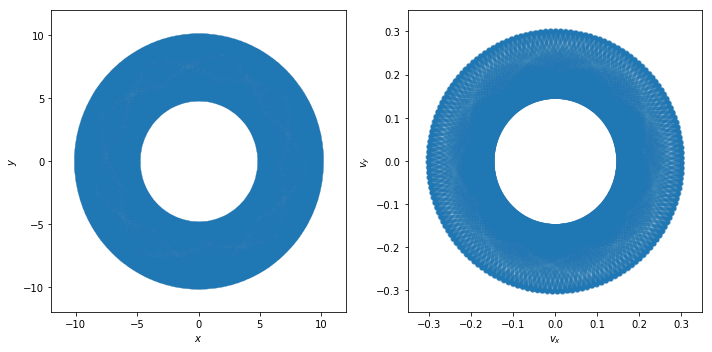

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

axes[0].plot(x_cy[:,0], x_cy[:,1], marker='.', linestyle='none', alpha=0.1)
axes[0].set_xlim(-12, 12)
axes[0].set_ylim(-12, 12)

axes[0].set_xlabel('$x$')
axes[0].set_ylabel('$y$')

# ---

axes[1].plot(v_cy[:,0], v_cy[:,1], marker='.', linestyle='none', alpha=0.1)
axes[1].set_xlim(-0.35, 0.35)
axes[1].set_ylim(-0.35, 0.35)

axes[1].set_xlabel('$v_x$')
axes[1].set_ylabel('$v_y$')

fig.tight_layout()

We've just gone from 2 seconds to 10 microseconds...5 orders of magnitude in speedup.

## Cython and Python Modules

One of the great things about Cython is that once we have Cython code that we're happy with, rather than compiling it every time we want to run something, we can compile it as a library that can be imported as a Python modules.

I've placed a copy of our leapfrog integration code in the demos folder, and given it the suffix `pyx`, allowing us to compile it with the Cython compiler:

In [37]:
%cd ../demos/cython
%ls

[Errno 2] No such file or directory: '../demos/cython'
/home/joyvan/demos/cython
leapfrog.pyx


In [39]:
!cython -a leapfrog.pyx

/opt/conda/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /home/joyvan/demos/cython/leapfrog.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [40]:
%ls

leapfrog.c  leapfrog.html  leapfrog.pyx


We can see that there is generated C code (have a look if want), as well as an html file with the annotation summary:

In [44]:
import IPython
IPython.display.HTML(filename='./leapfrog.html')

We can now compile our generated C code:

In [50]:
!gcc -fwrapv -fPIC -O2 -Wall --std=gnu99 -Wp,-w -Wno-unused-function \
    -I/opt/conda/include/ \
    -I/opt/conda/lib/python3.7/site-packages/numpy/core/include \
    -I/opt/conda/include/python3.7m/ \
    -o leapfrog.o -c leapfrog.c

In [51]:
!gcc -shared -o leapfrog.so leapfrog.o

In [ ]:
Let's have a look at what was generated:

In [52]:
%ls

leapfrog.c  leapfrog.html  leapfrog.o  leapfrog.pyx  leapfrog.so*


We now have a `leapfrog` module we can import into our code

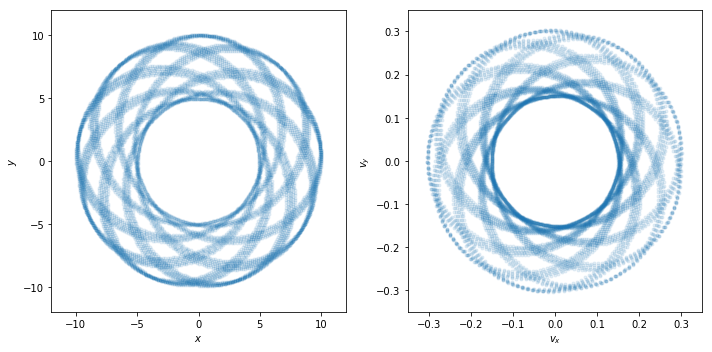

In [54]:
from astropy.constants import G
import astropy.units as u
import matplotlib.pyplot as plt

# Import our leapfrog integration module
from leapfrog import leapfrog_integrate

def main():
    # The unit system we'll use:
    units = [u.Myr, u.kpc, u.Msun]
    _G = G.decompose(units).value

    # Initial conditions
    x0 = [10., 0, 0]
    v0 = [0, 0.15, 0]

    # Parameters of the Hernquist potential model
    m = 1E11 # Msun
    c = 1. # kpc

    # Timestep in Myr
    dt = 1.
    n_steps = 10000 # 10 Gyr

    t, x, v = leapfrog_integrate(x0, v0, dt, n_steps,
                                 hernquist_args=(_G, m, c))

    # Plot the orbit
    fig, axes = plt.subplots(1, 2, figsize=(10,5))

    axes[0].plot(x[:,0], x[:,1], marker='.', linestyle='none', alpha=0.1)
    axes[0].set_xlim(-12, 12)
    axes[0].set_ylim(-12, 12)

    axes[0].set_xlabel('$x$')
    axes[0].set_ylabel('$y$')

    # ---

    axes[1].plot(v[:,0], v[:,1], marker='.', linestyle='none', alpha=0.1)
    axes[1].set_xlim(-0.35, 0.35)
    axes[1].set_ylim(-0.35, 0.35)

    axes[1].set_xlabel('$v_x$')
    axes[1].set_ylabel('$v_y$')

    fig.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

As you can see, we Cython is a pretty powerful tool when it comes to producing optimised Python code.  It does, however, come with a learning curve.

You don't need to focus on writing all of your Python code in Cython...rather you should focus on the computationally intensive parts (which is likely about 20% of your code).  Or try to use modules (like NumPy and SciPy) that leverage Cython's capabilities.

We'll now look at something that may be a little easier...

# Numba

Numba provides code compilation like Cython, but does so in a simple, easy-to-use fashion.  


#### Numba Features

* **Function compiler**  
Numba compiles Python functions, not whole programs (like Cython)  
<br>
* **Type specialisation**
We've seen the performance boost from specifying specific types for your variables...Numba speeds up Python functions by generating specific data types.  
<br>
* **Just-in-Time compilation**  
Numba translates your Python function on the fly.  The generated code is cached for later use  
<br>
* **Numerical focus**  
Numba isn't really designed for things like strings or Python lists; it's focus is on numerical types like `int` and `float`.


<br>
To use Numba all that's needed is to add a decorator (similar to a C/C++ pragma or Fortran directive) to compute kernel

```python
from numba import jit

@jit
def func(x):
    # some loop or comutationally intensive kernel
    return x
```

Python code with the `@jit` decorator are compiled at runtime (just-in-time) using the LLVM compiler, producing code that is on par with C/C++ and Fortran.

Here's what it look like under the hood:
<img src="../img/numba_process.png" style="height:450px">

## Numba Basics

Let's start with some simple functions, like computing a hypotenuse:

In [1]:
from numba import jit
import math

@jit
def hypot(x, y):
    x = abs(x);
    y = abs(y);
    t = min(x, y);
    x = max(x, y);
    t = t / x;
    return x * math.sqrt(1+t*t)

As you can see there's nothing in our demo directory.  The first time we call this function Numba is going to compile it:

In [2]:
hypot(3.0,4.0)

5.0

If we jumped into our container we could see generated machine code, as well as an additional file with a `.py_func` suffix.  This is a copy of the original Python code, that we can use to verify that our Numba generated code is producing the same answer:

In [3]:
hypot.py_func(3.0, 4.0)

5.0

Now let's see how it performs.  First we'll try the original Python code:

In [4]:
%timeit hypot.py_func(3.0, 4.0)

870 ns ± 19.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Now let's see the Number version:

In [5]:
%timeit hypot(3.0, 4.0)

326 ns ± 39.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Not bad...about 3 times faster.  What about Python's built-in `hypot` function?

In [6]:
%timeit math.hypot(3.0, 4.0)

160 ns ± 3.12 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


Numba introduces some overhead during function calls, hence the slowdown.

## Bubblesort Demo

We're going to walk through a demo of the [Bubblesort](https://en.wikipedia.org/wiki/Bubble_sort) algorithm.  This is basically a comparison sort (we step through the elements and swap them if they're out of order).  The name comes from the fact that the larger elements "bubble" to the top.  It's actually a pretty slow algorithm, but it's simple to code.

For a nice visual of it:
https://www.youtube.com/watch?v=lUqFelc84XE

### Python Implementation

First let's write the standard Python version of Bubblesort:

In [7]:
def python_bubblesort(a_list):
    """ Plain Python implementation of bubble sort (sorts in place) """
    count = len(a_list)
    for i in range(count):
        for j in range(1, count):
            if a_list[j] < a_list[j-1]:
                a_list[j-1], a_list[j] = a_list[j], a_list[j-1]
    return a_list

In [9]:
import random
random.seed(12345)

x = [random.randint(1,100) for num in range(1, 100)]
assert(sorted(x) == python_bubblesort(x))
print('Sorted')

Sorted


### Cython Implementation

We'll actually write this a few different ways:

* Straight Cython (no type definitions)
* With type type definitions
* Converting between Python lists objects and C arrays
* Using NumPy memoryview

In [12]:
%%cython
cimport cython
cpdef cython_bubblesort_notypes(a_list):
    """ 
    The Python implementation of bubble sort compiled
    via Cython without C type definitions.
    
    """
    count = len(a_list)
    for i in range(count):
        for j in range(1, count):
            if a_list[j] < a_list[j-1]:
                a_list[j-1], a_list[j] = a_list[j], a_list[j-1]
    return a_list

In [13]:
%%cython
cimport cython
cpdef cython_bubblesort_ctypes(a_list):
    """ 
    Cython implementation of bubble sort with static
    type declarations.
    
    """
    cdef int count, i, j # static type declarations
    count = len(a_list)
    for i in range(count):
        for j in range(1, count):
            if a_list[j] < a_list[j-1]:
                a_list[j-1], a_list[j] = a_list[j], a_list[j-1]
    return a_list

In [14]:
%%cython
cimport cython
from libc.stdlib cimport malloc, free

cpdef cython_bubblesort_clist(a_list):
    """ 
    The Cython implementation of bubble sort with internal
    conversion between Python list objects and C arrays.
    
    """
    cdef int *c_list
    c_list = <int *>malloc(len(a_list)*cython.sizeof(int))
    cdef int count, i, j # static type declarations
    count = len(a_list)
    
    # convert Python list to C array
    for i in range(count):
        c_list[i] = a_list[i]

    for i in range(count):
        for j in range(1, count):
            if c_list[j] < c_list[j-1]:
                c_list[j-1], c_list[j] = c_list[j], c_list[j-1]

    # convert C array back to Python list
    for i in range(count):
        a_list[i] = c_list[i]
        
    free(c_list)
    return a_list

In [15]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
@cython.boundscheck(False) 
@cython.wraparound(False)
cpdef cython_bubblesort_numpy(inp_ary):
    """ The Cython implementation of Bubblesort with NumPy memoryview."""
    cdef unsigned long length, i, swapped, ele, temp
    cdef long[:] np_ary = inp_ary
    length = np_ary.shape[0]
    swapped = 1
    for i in range(0, length):
        if swapped: 
            swapped = 0
            for ele in range(0, length-i-1):
                if np_ary[ele] > np_ary[ele + 1]:
                    temp = np_ary[ele + 1]
                    np_ary[ele + 1] = np_ary[ele]
                    np_ary[ele] = temp
                    swapped = 1
    return inp_ary

### Numba Implementation

We'll do 2 versions of this:

* Standard version (in-place sorting)
* Using NumPy arrays

In-place sorting simply means we aren't going to use a second data structure to store sorted values (we overwrite our original list as we iterate through the unsorted list).

In [16]:
from numba import jit
@jit
def numba_bubblesort(a_list):
    """ Numba implementation of bubble sort (sorts in place) """
    count = len(a_list)
    for i in range(count):
        for j in range(1, count):
            if a_list[j] < a_list[j-1]:
                a_list[j-1], a_list[j] = a_list[j], a_list[j-1]
    return a_list

In [17]:
from numba import jit
@jit
def numba_bubblesort_numpy(np_ary):
    """ 
    Numba implementation of bubble sort (sorts in place),
    It is identical to numba_bubble_sort(), but we will feed
    a numpy array type to this function.
    
    """
    count = np_ary.shape[0]
    for i in range(count):
        for j in range(1, count):
            if np_ary[j] < np_ary[j-1]:
                np_ary[j-1], np_ary[j] = np_ary[j], np_ary[j-1]
    return np_ary

### Verification

Let's double-check everything works for the different versions:

In [18]:
import random
import copy
import numpy as np
random.seed(12345)

l = np.asarray([random.randint(1,1000) for num in range(1, 1000)])
l_sorted = np.sort(l)
for f in [python_bubblesort, cython_bubblesort_ctypes, 
          cython_bubblesort_notypes, cython_bubblesort_clist, 
          cython_bubblesort_numpy, numba_bubblesort, 
          numba_bubblesort_numpy]:
    assert(l_sorted.all() == f(copy.copy(l)).all())
print('Bubblesort works correctly')

Bubblesort works correctly


### Timing

Now we'll time every version and plot the results (this will take a few minutes):

In [19]:
import timeit
import random
import copy
import numpy as np
random.seed(4567)

def make_copy(l):
    return copy.deepcopy(l)

funcs = ['python_bubblesort', 'numba_bubblesort', 
         'cython_bubblesort_notypes', 'cython_bubblesort_ctypes', 
         'cython_bubblesort_clist', 'cython_bubblesort_numpy', 
         'numba_bubblesort_numpy'
         ]

orders_n = [10**n for n in range(1, 5)]
timings = {f:[] for f in funcs}


for n in orders_n:
    l = [np.random.randint(n) for num in range(n)]
    for f in funcs:
        l_copy = make_copy(l)
        if f in ['numba_bubblesort_numpy', 'cython_bubblesort_numpy']:
            l_copy = np.asarray(l_copy)
        timings[f].append(min(timeit.Timer('%s(l_copy)' %f, 
                      'from __main__ import %s, l_copy' %f)
                              .repeat(repeat=5, number=10)))

In [31]:
import platform
import multiprocessing
#from llvm import __version__ as llvm__version__
from numba import __version__ as numba__version__
from cython import __version__ as cython__version__

def print_sysinfo():
    
    print('\nPython version:', platform.python_version())
    print('compiler        :', platform.python_compiler())
    print('Cython version  :', cython__version__)
    print('NumPy version   :', np.__version__)
    print('Numba version   :', numba__version__)
    #print('llvm version    :', llvm__version__)
    
    print('\nsystem   :', platform.system())
    print('release  :', platform.release())
    print('machine  :', platform.machine())
    print('processor:', platform.processor())
    print('CPU count  :', multiprocessing.cpu_count())
    print('interpreter:', platform.architecture()[0])
    print('\n\n')

In [32]:
%matplotlib inline

In [33]:
import matplotlib.pyplot as plt

def plot(timings, title, ranked_labels, labels, orders_n):
    plt.rcParams.update({'font.size': 12})

    fig = plt.figure(figsize=(11,10))
    for lb in ranked_labels:
        plt.plot(orders_n, timings[lb], alpha=0.5, label=labels[lb], 
                 marker='o', lw=3)
    plt.xlabel('sample size n (items in the list)')
    plt.ylabel('time per computation for 10 loops in seconds')
    plt.xlim([min(orders_n) / 10, max(orders_n)* 10])
    plt.legend(loc=2)
    plt.grid()
    plt.xscale('log')
    plt.yscale('log')
    plt.title(title)
    plt.show()

In [34]:
import prettytable

def summary_table(ranked_labels):
    fit_table = prettytable.PrettyTable(['n=%s' %orders_n[-1], 
                                         'bubblesort function' ,
                                         'time in sec.',
                                         'rel. performance gain'])
    fit_table.align['bubblesort function'] = 'l'
    for entry in ranked_labels:
        fit_table.add_row(['', labels[entry[1]], round(entry[0], 2), 
                           round(ranked_labels[0][0]/entry[0], 2)])
    print(fit_table)

In [35]:
title = 'Performance of bubblesort in Python, Cython, and Numba'

labels = {'python_bubblesort':'(C)Python - Python lists', 
          'numba_bubblesort': 'Numba - Python lists', 
          'cython_bubblesort_ctypes': 'Cython - with C types, Python lists',
          'cython_bubblesort_notypes': 'Cython - no type declarations, Python lists',
          'cython_bubblesort_clist': 'Cython - Python lists with to-C-array-conversion',
          'cython_bubblesort_numpy': 'Cython - NumPy arrays memoryview',
          'numba_bubblesort_numpy': 'Numba - NumPy arrays'
          }

ranked_by_time = sorted([(time[1][-1],time[0]) for time in timings.items()], reverse=True)

## Results


Python version: 3.7.3
compiler        : GCC 7.3.0
Cython version  : 0.29.6
NumPy version   : 1.15.4
Numba version   : 0.42.1

system   : Linux
release  : 4.9.125-linuxkit
machine  : x86_64
processor: x86_64
CPU count  : 4
interpreter: 64bit





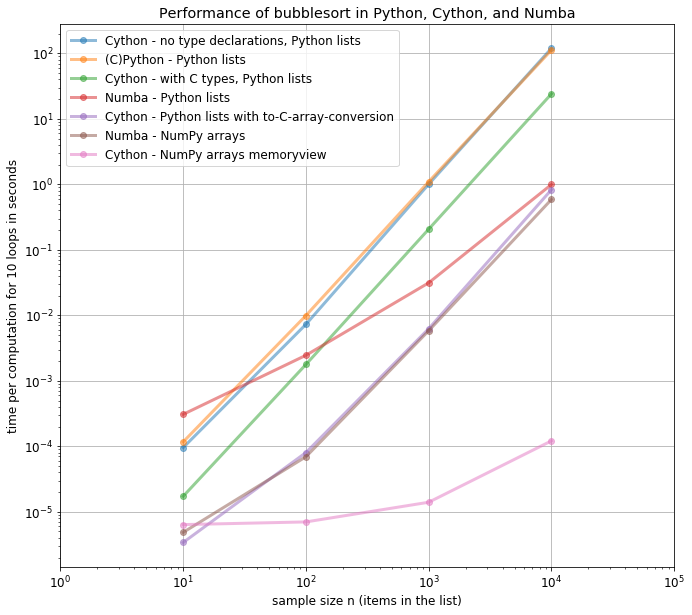

+---------+--------------------------------------------------+--------------+-----------------------+
| n=10000 | bubblesort function                              | time in sec. | rel. performance gain |
+---------+--------------------------------------------------+--------------+-----------------------+
|         | Cython - no type declarations, Python lists      |    119.59    |          1.0          |
|         | (C)Python - Python lists                         |    112.4     |          1.06         |
|         | Cython - with C types, Python lists              |    24.11     |          4.96         |
|         | Numba - Python lists                             |     1.0      |         120.1         |
|         | Cython - Python lists with to-C-array-conversion |     0.83     |         144.22        |
|         | Numba - NumPy arrays                             |     0.59     |         203.16        |
|         | Cython - NumPy arrays memoryview                 |     0.0      |     

In [36]:
print_sysinfo()
plot(timings, title, [l for t,l in ranked_by_time], labels, orders_n)
summary_table(ranked_by_time)

### Takeaways

It's pretty apparent that Cython is the winner.  That's no surprise as we're generating machine code for the entire application and accessing C arrays directly.  However, it comes with the cost of extra coding work.  

However, Numba provides pretty good speedup with minimal effort, particularly when paired with NumPy objects.

Some main points to remember:

* **Other People's Code**  
Chances are someone has already written a better version of what you want to do, don't reinvent the wheel

* **Performant Third-Party Libraries**  
That's not to say you should grab whatever you find on the internet; projects like NumPy and SciPy should form the basis of any code you're going to write

* **Data Structures**  
You'll want to think about what your data is and how you have it structured.  Python lists are convenient, but they're terrible in terms of performance.  NumPy arrays will give you large speed improvements, and often times may be all you need to do.